In [1]:
from lhotse.audio import Recording, RecordingSet
from lhotse.utils import Pathlike, check_and_rglob, urlretrieve_progress
from lhotse.supervision import SupervisionSegment, SupervisionSet
from typing import Dict, Optional, Union, List
from collections import defaultdict
from lhotse.dataset import K2SpeechRecognitionIterableDataset
from torch.utils.data import DataLoader
from lhotse import CutSet, Fbank, LilcomFilesWriter, WavAugmenter
from concurrent.futures import ProcessPoolExecutor
from lhotse.dataset import SpeechRecognitionDataset
import torch

/home/neo/Desktop/projects/lhotse/lhotse/augmentation/torchaudio.py:13: UserWarning: Torchaudio SoX effects chains are only introduced in version 0.7 - please upgrade your PyTorch to 1.7+ and torchaudio to 0.7+ to use them.
  warnings.warn('Torchaudio SoX effects chains are only introduced in version 0.7 - '


In [2]:
download_urls = {
    'dev_spk.list': 'https://raw.githubusercontent.com/kaldi-asr/kaldi/master/egs/timit/s5/conf/dev_spk.list',
    'test_spk.list': 'https://raw.githubusercontent.com/kaldi-asr/kaldi/master/egs/timit/s5/conf/test_spk.list',
    'phones.60-48-39.map': 'https://raw.githubusercontent.com/kaldi-asr/kaldi/master/egs/timit/s5/conf/phones.60-48-39.map'
}

In [3]:
audio_dir = '/home/neo/TIMIT/TIMIT/TRAIN/'
transcripts_dir = '/home/neo/TIMIT/TIMIT/TRAIN/'

In [4]:
audio_paths = check_and_rglob(audio_dir, '*.WAV')

In [5]:
phone_paths = check_and_rglob(transcripts_dir, '*.PHN')
char_paths = check_and_rglob(transcripts_dir, '*.TXT')

In [6]:
char_paths[10].as_posix()

'/home/neo/TIMIT/TIMIT/TRAIN/DR1/FDAW0/SA1.TXT'

In [7]:
groups = []
name_to_text = {f'{p.parent.stem}_{p.stem}': p for p in phone_paths}

In [8]:
for ap in audio_paths:
    name = f'{ap.parent.stem}_{ap.stem}'
    groups.append({'id': name, 'audio': ap, 'phone-label': name_to_text[f'{name}']})

In [9]:
absolute_paths = True

In [10]:
recordings = RecordingSet.from_recordings(
        Recording.from_sphere(group['audio'], group['id'], relative_path_depth=None if absolute_paths else 3)
        for group in groups
    )

In [11]:
supervision_groups = []
for phone_path, char_path in zip(phone_paths, char_paths):
    name = f'{phone_path.parent.stem}_{phone_path.stem}'
    supervision_groups.append({'id': name, 'text': phone_path, 'char': char_path})

In [12]:
supervision_groups[0]

{'id': 'FCJF0_SA1',
 'text': PosixPath('/home/neo/TIMIT/TIMIT/TRAIN/DR1/FCJF0/SA1.PHN'),
 'char': PosixPath('/home/neo/TIMIT/TIMIT/TRAIN/DR1/FCJF0/SA1.TXT')}

In [13]:
# for file_to_be_downloaded in download_urls.keys():
#     urlretrieve_progress(f'{download_urls[file_to_be_downloaded]}', filename=file_to_be_downloaded, desc=f'Downloading {file_to_be_downloaded}')

In [39]:
def read_phn_file(phn_file: Pathlike) -> List[str]:
    with open(phn_file, encoding='utf-8') as f:
        contents = f.readlines()
    contents = ' '.join([row.strip().split()[-1] for row in contents])
    return contents

In [40]:
def load_phone_map(phone_map: Pathlike) -> Dict:
    with open(phone_map, encoding='utf-8') as f:
        contents = f.readlines()
    contents = [row.strip().split('\t') for row in contents]
    map_dict = {}
    for row in contents:
        if row[0] != 'q':
            map_dict[row[0]] = row[1:]
        else:
            map_dict[row[0]] = ['q', 'q']
    return map_dict

In [41]:
recordings[supervision_groups[0]['id']]

Recording(id='FCJF0_SA1', sources=[AudioSource(type='file', channels=[0], source='/home/neo/TIMIT/TIMIT/TRAIN/DR1/FCJF0/SA1.WAV')], sampling_rate=16000, num_samples=46797, duration=2.9248125, transforms=None)

In [42]:
supervisions = []
for entry in supervision_groups:
    recording = recordings[entry['id']]
    segment = SupervisionSegment(
                        id=entry['id'],
                        recording_id=entry['id'],
                        start=0.0,
                        duration=recording.duration,
                        channel=0,
                        language='English',
                        speaker=entry['id'].split('_')[0],
                        text=read_phn_file(entry['text']),
                        gender=entry['id'][0]
                    )
    supervisions.append(segment)

In [43]:
supervisions[0]

SupervisionSegment(id='FCJF0_SA1', recording_id='FCJF0_SA1', start=0.0, duration=2.9248125, channel=0, text='h# sh ix hv eh dcl jh ih dcl d ah kcl k s ux q en gcl g r ix s ix w ao sh epi w ao dx axr ao l y ih axr h#', language='English', speaker='FCJF0', gender='F', custom=None)

In [44]:
recording_set = RecordingSet.from_recordings(recordings)

In [45]:
supervision_set = SupervisionSet.from_segments(supervisions)

In [66]:
cuts = CutSet.from_manifests(
    recordings=recording_set,
    supervisions=supervision_set
).cut_into_windows(duration=5)

In [67]:
idx = list(cuts.ids)[0]

In [72]:
cuts[idx].duration

2.9248125

In [48]:
num_jobs = 1

In [73]:
with LilcomFilesWriter(f'feats') as storage, ProcessPoolExecutor(num_jobs) as ex:
        cut_set = CutSet.from_manifests(
            recordings=recording_set,
            supervisions=supervision_set
        ).compute_and_store_features(
            extractor=Fbank(),
            storage=storage,
            executor=ex
        )

/home/neo/Desktop/projects/lhotse/lhotse/cut.py:1574: UserWarning: ProcessPoolExecutor using a "fork" multiprocessing detected. In some circumstances this can crash or hang the program, e.g. when using  data augmentation libsox wrappers like WavAugment or torchaudio. We suggest passing an extra argument to initialize the executor: ProcessPoolExecutor(..., mp_context=multiprocessing.get_context("spawn"))
  warnings.warn('ProcessPoolExecutor using a "fork" multiprocessing detected. '


In [106]:
cmvn = cut_set.compute_global_feature_stats(storage_path='cmvn_stats')

In [74]:
cut_set.to_json(f'cuts_train.json.gz')

In [75]:
dataset = SpeechRecognitionDataset(cut_set)

In [76]:
sample = dataset[100]

In [77]:
sample['features'][-1]

tensor([-15.9499, -15.9415, -15.9318, -15.9479, -15.9374, -15.9557, -15.9539,
        -15.3761, -15.9461, -15.9362, -15.9268, -15.9306, -15.9449, -15.1277,
        -14.5215, -12.9106, -12.4238, -13.1958, -12.9698, -14.4832, -15.2195,
        -14.8947, -12.3614, -12.5410, -12.3269, -13.0692, -14.2538, -14.4072,
        -13.5613, -11.9741, -12.4021, -11.7048, -11.5037, -12.3880, -11.3294,
        -10.8156, -10.3606, -10.9236, -11.0328, -10.4215])

In [78]:
import matplotlib.pyplot as plt

In [79]:
sample['features'].shape

torch.Size([358, 40])

In [109]:
train_dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [110]:
for batch in train_dl:
    print(batch)
    a = batch
    break

{'features': tensor([[[-15.9375, -15.9448, -15.9513,  ..., -10.7895, -10.9001, -10.8415],
         [-15.9385, -15.9539, -15.9426,  ..., -10.3620, -10.9087, -10.4900],
         [-15.9394, -15.9324, -15.9463,  ..., -10.7017, -10.1859, -10.2245],
         ...,
         [-15.9558, -15.9346, -15.9462,  ..., -10.9601, -11.0980, -11.3259],
         [-15.9565, -15.9284, -15.9463,  ..., -11.2628, -10.9925, -11.1657],
         [-15.9572, -15.9542, -15.9380,  ..., -10.5615, -10.5196, -11.2469]]]), 'text': ['h# ae z ix pcl p r ix kcl k ao sh ih n ax q aw q l ao z bcl b ao tcl g ah n pcl p aw dx er f ih dh ix r s tcl t r ao ng hv ow l dcl d h#'], 'supervisions_mask': tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 

In [ ]:
def apply_cmvn(features):
    normed_feats = 

In [119]:
new_feats = (a['features'][0] - cmvn['norm_means']) / cmvn['norm_stds']

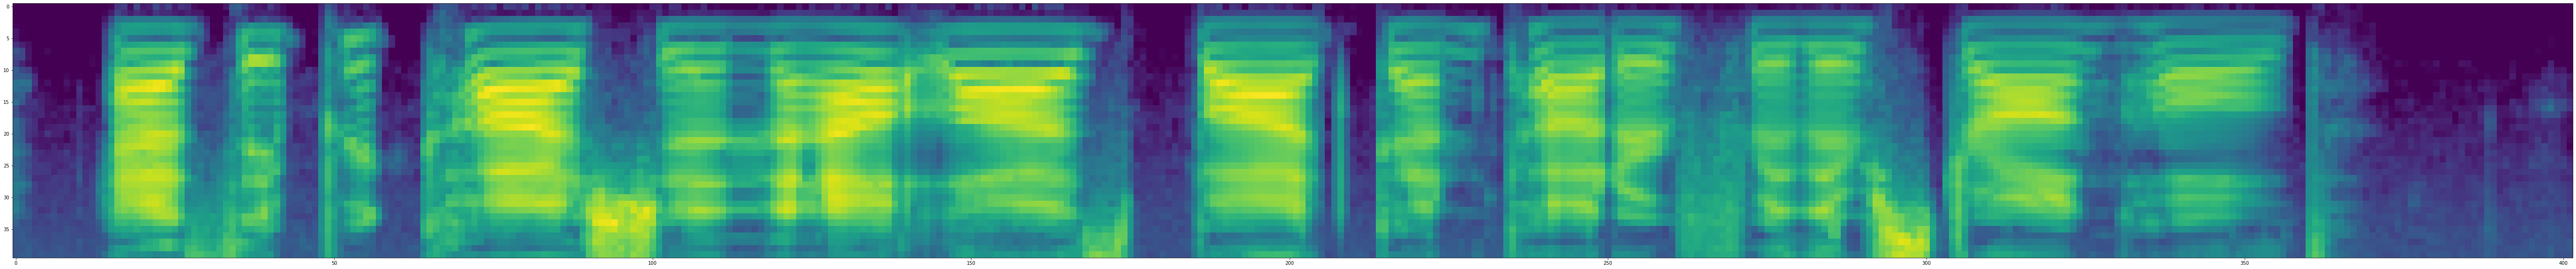

In [123]:
plt.figure(figsize=(100,10))
plt.imshow(a['features'][0].T)

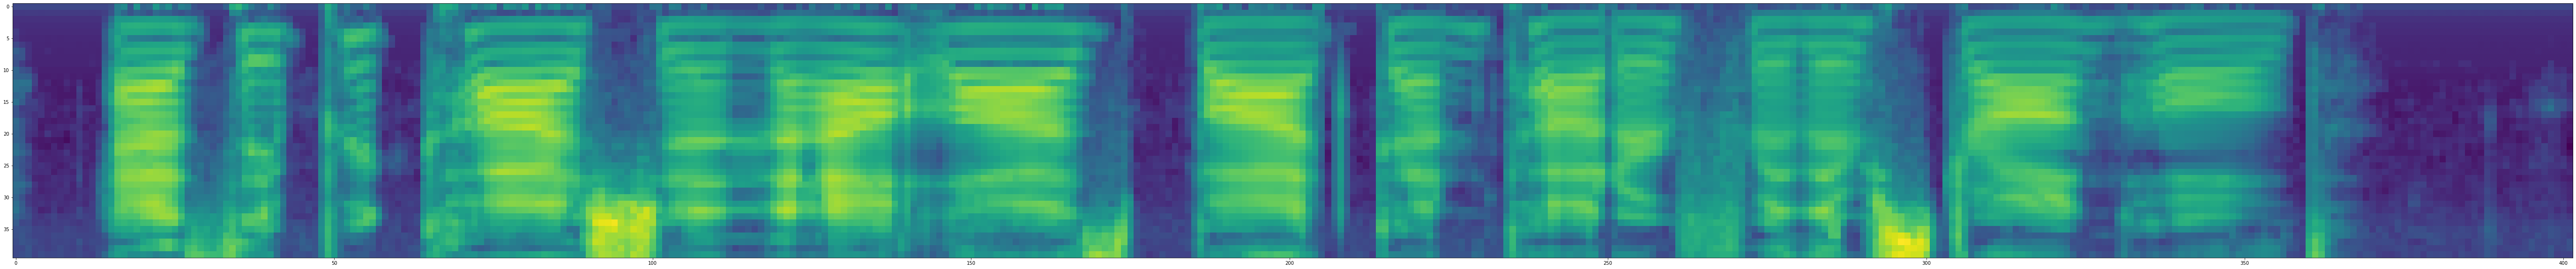

In [124]:
plt.figure(figsize=(100,10))
plt.imshow(new_feats.T)

In [126]:
a['features'][0].T

tensor([[-15.9375, -15.9385, -15.9394,  ..., -15.9558, -15.9565, -15.9572],
        [-15.9448, -15.9539, -15.9324,  ..., -15.9346, -15.9284, -15.9542],
        [-15.9513, -15.9426, -15.9463,  ..., -15.9462, -15.9463, -15.9380],
        ...,
        [-10.7895, -10.3620, -10.7017,  ..., -10.9601, -11.2628, -10.5615],
        [-10.9001, -10.9087, -10.1859,  ..., -11.0980, -10.9925, -10.5196],
        [-10.8415, -10.4900, -10.2245,  ..., -11.3259, -11.1657, -11.2469]])

In [127]:
new_feats.T

tensor([[-1.1288, -1.1292, -1.1297,  ..., -1.1366, -1.1369, -1.1372],
        [-1.3879, -1.3910, -1.3837,  ..., -1.3844, -1.3824, -1.3911],
        [-1.5543, -1.5517, -1.5528,  ..., -1.5528, -1.5528, -1.5503],
        ...,
        [-1.0142, -0.8718, -0.9849,  ..., -1.0710, -1.1718, -0.9382],
        [-1.1101, -1.1131, -0.8668,  ..., -1.1776, -1.1417, -0.9805],
        [-1.1154, -0.9939, -0.9021,  ..., -1.2828, -1.2275, -1.2555]],
       dtype=torch.float64)